#Projeto para o portifolio com mentalidade RevOps


In [17]:
# Instalação necessária no ambiente (como Colab)
!pip install pandasql

# Importações essenciais
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Constante com a URL dos dados (Torna o Notebook portátil)
URL_DADOS_RAW = 'https://raw.githubusercontent.com/RafaelOCorrea/analise-revops-rentabilidade/refs/heads/main/df_sales.csv'

# Função psql para facilitar a chamada de consultas SQL
psql = lambda q: sqldf(q, globals())

# 1. CARREGAMENTO E CRIAÇÃO DA MARGEM DE LUCRO (SQL)
df_sales = pd.read_csv(URL_DADOS_RAW, header=0)

query_margem = """
SELECT
    d.*, -- Seleciona todas as colunas existentes

    -- CRIAÇÃO DA MARGEM DE LUCRO (Profit / Sales). Usa CASE WHEN para evitar divisão por zero.
    CASE
        WHEN d.sales = 0 THEN 0.00
        ELSE (d.profit / d.sales)
    END AS margem_lucro

FROM
    df_sales AS d;
"""

# Executa a query e armazena o resultado no DataFrame
df_sales = psql(query_margem)

# O Pandasql estava duplicando a coluna 'margem_lucro'. Removemos a última coluna duplicada (índice -1)
# para garantir que o DataFrame tenha a estrutura esperada.
if df_sales.columns[-1] == 'margem_lucro' and df_sales.columns[-2] == 'margem_lucro':
    df_sales = df_sales.iloc[:, :-1]

# Exibe o resultado e informações iniciais
print("DataFrame Extraído com Coluna 'margem_lucro' Criada:")
print(f"\nTotal de linhas extraídas: {len(df_sales)}")
df_sales.info()

DataFrame Extraído com Coluna 'margem_lucro' Criada:

Total de linhas extraídas: 51290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order_id         51290 non-null  object 
 1   order_date       51290 non-null  object 
 2   ship_date        51290 non-null  object 
 3   ship_mode        51290 non-null  object 
 4   customer_name    51290 non-null  object 
 5   segment          51290 non-null  object 
 6   state            51290 non-null  object 
 7   country          51290 non-null  object 
 8   market           51290 non-null  object 
 9   region           43582 non-null  object 
 10  product_id       51290 non-null  object 
 11  category         46306 non-null  object 
 12  sub_category     51290 non-null  object 
 13  product_name     51290 non-null  object 
 14  sales            51290 non-null  float64
 15  quantity         

In [18]:
# 1. TRATAMENTO DE VALORES NULOS (Preenchimento)
# Preenche os valores nulos em colunas categóricas para manter a integridade dos dados.
df_sales['region'] = df_sales['region'].fillna('Desconhecida')
df_sales['category'] = df_sales['category'].fillna('Sem Categoria')


# 2. CORREÇÃO ESSENCIAL: CONVERTER DATAS PARA DATETIME
# Necessário para calcular a diferença de tempo e para plotagens de séries temporais.
df_sales['ship_date'] = pd.to_datetime(df_sales['ship_date'])
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])


# 3. FEATURE ENGINEERING: TEMPO DE ENVIO
# Calcula a diferença entre a data de envio e a data do pedido, em dias inteiros.
df_sales['Tempo_Envio_Dias'] = (df_sales['ship_date'] - df_sales['order_date']).dt.days

print("Status: Dados tratados e 'Tempo_Envio_Dias' criada com sucesso.")

Status: Dados tratados e 'Tempo_Envio_Dias' criada com sucesso.


In [19]:
# ANÁLISE DE RENTABILIDADE POR SEGMENTO
df_lucro_segmento = df_sales.groupby('segment').agg(
    Lucro_Total=('profit', 'sum'),
    Vendas_Total=('sales', 'sum'),
    Qtd_Pedidos=('order_id', 'nunique')
).reset_index()

# Ordena por Lucro Total para visualizar o melhor/pior segmento
df_lucro_segmento = df_lucro_segmento.sort_values(by='Lucro_Total', ascending=False)

print("\n--- Lucro Total por Segmento de Cliente ---")
# pd.set_option para formatar a exibição (apenas para este output)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df_lucro_segmento)


--- Lucro Total por Segmento de Cliente ---
       segment  Lucro_Total  Vendas_Total  Qtd_Pedidos
0     Consumer    749239.78    6508141.00        13104
1    Corporate    442785.86    3824808.00         7673
2  Home Office    277009.18    2309956.00         4687



--- Lucro Total e Médio por Categoria de Produto ---
          category  Lucro_Total  Vendas_Total  Lucro_Medio_Pedido  Qtd_Pedidos
3       Technology    603875.84    4289748.00               66.23         7648
1  Office Supplies    466960.40    3402548.00               16.53        17809
0        Furniture    263710.16    3719053.00               29.51         7555
2    Sem Categoria    134488.43    1231556.00               26.98         4537


/tmp/ipython-input-2874645494.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


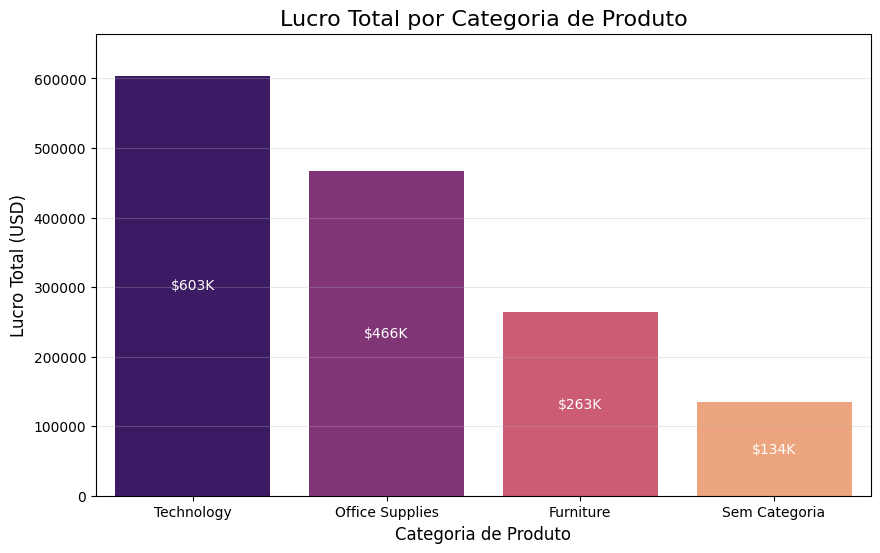

In [20]:
# 1. ANÁLISE DE RENTABILIDADE POR CATEGORIA
df_lucro_categoria = df_sales.groupby('category').agg(
    Lucro_Total=('profit', 'sum'),
    Vendas_Total=('sales', 'sum'),
    Lucro_Medio_Pedido=('profit', 'mean'),  # Lucro médio por item/pedido
    Qtd_Pedidos=('order_id', 'nunique')
).reset_index()

# Ordena por Lucro Total (Curva ABC)
df_lucro_categoria = df_lucro_categoria.sort_values(by='Lucro_Total', ascending=False).copy()

print("\n--- Lucro Total e Médio por Categoria de Produto ---")
print(df_lucro_categoria)


# CRIAÇÃO DO GRÁFICO (Lucro Total por Categoria)
df_viz = df_lucro_categoria.sort_values(by='Lucro_Total', ascending=False).copy()

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='category',
    y='Lucro_Total',
    data=df_viz,
    palette='magma' # Paleta sequencial de impacto
)

# FORMATO E TÍTULOS
plt.title('Lucro Total por Categoria de Produto', fontsize=16)
plt.xlabel('Categoria de Produto', fontsize=12)
plt.ylabel('Lucro Total (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, df_viz['Lucro_Total'].max() * 1.1) # Limite Y dinâmico

# EXIBIR VALOR DA BARRA (Centralizado em K)
for p in ax.patches:
    value = f"${int(p.get_height()/1000):,}K"

    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height() / 2,
        value,
        ha="center",
        va="center",
        color='white',
        fontsize=10
    )

plt.show()

--- Comparação de Margem (Média vs. Mediana) por Segmento ---
       segment  Margem_Media  Margem_Mediana
0     Consumer          0.05            0.17
1    Corporate          0.05            0.17
2  Home Office          0.05            0.17


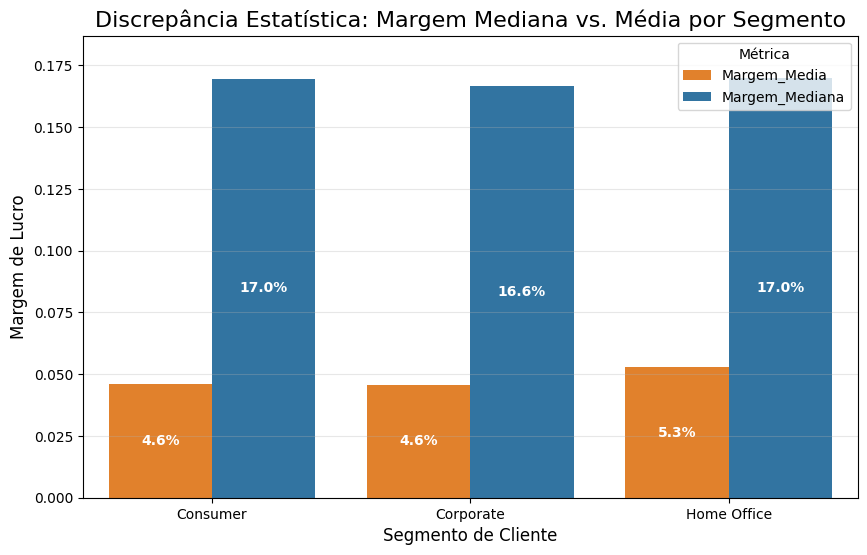

In [21]:
# O df_sales já contém 'Margem_Lucro' (do SQL)
# O código antigo foi limpo e substituído pela forma mais robusta de calcular Média e Mediana agrupadas

# 1. Agrupa por 'segment' e calcula Média e Mediana da Margem_Lucro
df_margem_comparada = df_sales.groupby('segment')['margem_lucro'].agg(['mean', 'median']).reset_index()

# 2. Renomeia as colunas para clareza
df_margem_comparada.columns = ['segment', 'Margem_Media', 'Margem_Mediana']

# 3. Exibe o resultado formatado
print("--- Comparação de Margem (Média vs. Mediana) por Segmento ---")
print(df_margem_comparada.round(4))


# PREPARAÇÃO PARA O GRÁFICO
# 'Derreter' (Melt) o DataFrame para o formato longo (ideal para gráficos agrupados).
df_plot = df_margem_comparada.melt(
    id_vars='segment',
    value_vars=['Margem_Media', 'Margem_Mediana'],
    var_name='Tipo_Margem',
    value_name='Valor'
)

# CRIAÇÃO DO GRÁFICO DE BARRAS AGRUPADAS (Média vs. Mediana)
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='segment',
    y='Valor',
    hue='Tipo_Margem',
    data=df_plot,
    # Paleta customizada: Azul (Típica/Saudável), Laranja (Contaminada/Real)
    palette={'Margem_Mediana': '#1f77b4', 'Margem_Media': '#ff7f0e'}
)

# FORMATO E TÍTULOS
plt.title('Discrepância Estatística: Margem Mediana vs. Média por Segmento', fontsize=16)
plt.xlabel('Segmento de Cliente', fontsize=12)
plt.ylabel('Margem de Lucro', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, df_plot['Valor'].max() * 1.1) # Limite Y dinâmico
plt.legend(title='Métrica', loc='upper right')

# EXIBIR VALOR DA BARRA (Em porcentagem, CENTRALIZADO)
for p in ax.patches:
    value = p.get_height()

    if value == 0:
        continue

    formatted_value = f"{value * 100:.1f}%"

    ax.text(
        p.get_x() + p.get_width() / 2,
        value / 2,
        formatted_value,
        ha="center",
        va="center",
        color='white',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

--- Média de Prejuízo por Transação Deficitária (Top 5) ---
   sub_category  profit  Abs_Perda
16       Tables -290.57     290.57
11     Machines -173.29     173.29
1    Appliances -167.52     167.52
4     Bookcases -141.49     141.49
6       Copiers -136.28     136.28


/tmp/ipython-input-1859077677.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


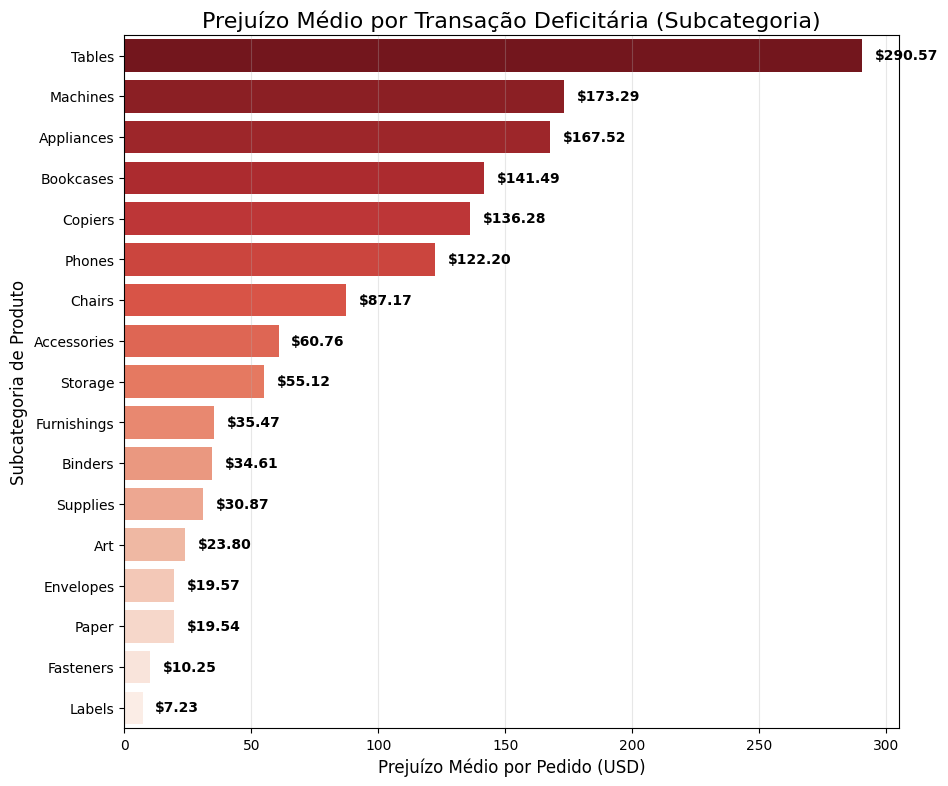

In [22]:
# CÁLCULO REAL: PREJUÍZO MÉDIO POR SUBCATEGORIA

# 1. ISOLAR O PREJUÍZO: Filtra o DataFrame para incluir SOMENTE pedidos com lucro negativo
df_prejuizo = df_sales[df_sales['profit'] < 0].copy()

# 2. QUANTIFICAR A PERDA: Agrupa por sub_category e calcula o Prejuízo Médio
df_perda_subcategoria = df_prejuizo.groupby('sub_category')['profit'].mean().reset_index()

# 3. CRIAÇÃO DA COLUNA ABSOLUTA (Para plotar a MAGNITUDE da perda)
df_perda_subcategoria['Abs_Perda'] = df_perda_subcategoria['profit'].abs()

# 4. ORDENAÇÃO DOS DADOS: Ordena do MAIOR prejuízo (maior Abs_Perda) para o MENOR
df_viz = df_perda_subcategoria.sort_values(by='Abs_Perda', ascending=False).copy()

# Exibe o ranking de prejuízo (apenas para verificação)
print("--- Média de Prejuízo por Transação Deficitária (Top 5) ---")
print(df_viz.head().round(2))


# CRIAÇÃO DO GRÁFICO (Horizontal para melhor leitura de rótulos)

plt.figure(figsize=(10, 9))
ax = sns.barplot(
    x='Abs_Perda',
    y='sub_category',
    data=df_viz,
    palette='Reds_r' # Paleta sequencial de Vermelho (claro->escuro)
)

# FORMATO E TÍTULOS
plt.title('Prejuízo Médio por Transação Deficitária (Subcategoria)', fontsize=16)
plt.xlabel('Prejuízo Médio por Pedido (USD)', fontsize=12)
plt.ylabel('Subcategoria de Produto', fontsize=12)
plt.grid(axis='x', alpha=0.3)


# EXIBIR VALOR DA BARRA (Em valor monetário)
for p in ax.patches:
    value = p.get_width()
    formatted_value = f"${value:.2f}"

    ax.text(
        value + 5,
        p.get_y() + p.get_height() / 2,
        formatted_value,
        ha="left",
        va="center",
        color='black',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

--- Causa Raiz do Prejuízo em Mesas (Tables) ---
  discount  shipping_cost
0   43.06%          70.32


/tmp/ipython-input-1744518655.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


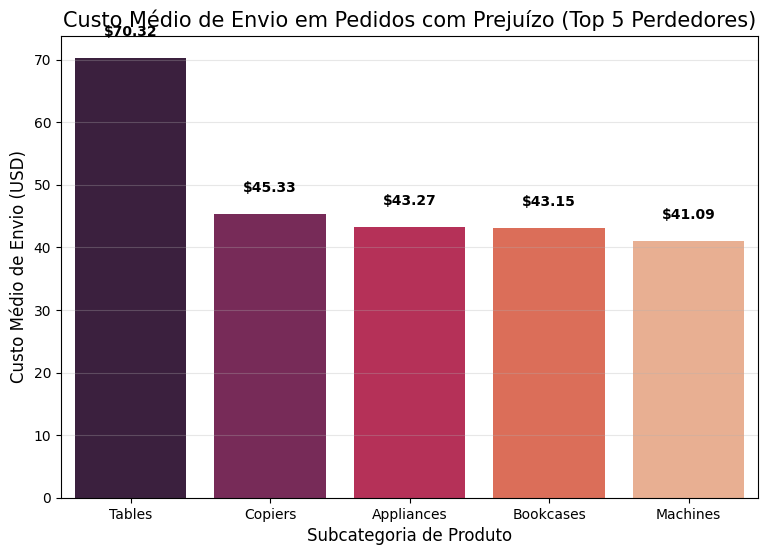

In [23]:
# 1. Causa Raiz: Desconto vs. Custo de Envio (Exemplo Tables)

# FILTRAGEM: Isolar pedidos de 'Tables' que resultaram em prejuízo
df_tables_prejuizo = df_sales[
    (df_sales['sub_category'] == 'Tables') &
    (df_sales['profit'] < 0) # Usamos 'profit < 0' para garantir
].copy()

# CÁLCULO DAS MÉTRICAS DE CAUSA RAIZ (Média de Desconto e Custo)
df_causa_raiz_tables = df_tables_prejuizo[[
    'discount',
    'shipping_cost'
]].mean().to_frame().T

# Formata as colunas
df_causa_raiz_tables['discount'] = df_causa_raiz_tables['discount'].apply(lambda x: f'{x * 100:.2f}%')
df_causa_raiz_tables['shipping_cost'] = df_causa_raiz_tables['shipping_cost'].round(2)

print("--- Causa Raiz do Prejuízo em Mesas (Tables) ---")
print(df_causa_raiz_tables)


# 2. Custo Médio de Envio em Pedidos com Prejuízo (Top 5)

top_perdedoras = ['Tables', 'Copiers', 'Bookcases', 'Appliances', 'Machines']

# FILTRAGEM E AGRUPAMENTO: Isola o prejuízo (profit < 0) e calcula o custo médio de envio
df_perda_envio = df_sales[df_sales['profit'] < 0].copy()
df_custo_envio_perda = df_perda_envio.groupby('sub_category')['shipping_cost'].mean().reset_index()

# FILTRA AS TOP 5 e ordena do maior custo para o menor
df_top_5_custo = df_custo_envio_perda[
    df_custo_envio_perda['sub_category'].isin(top_perdedoras)
].sort_values(by='shipping_cost', ascending=False)


# CRIAÇÃO DO GRÁFICO (Focado no custo)
plt.figure(figsize=(9, 6))
ax = sns.barplot(
    x='sub_category',
    y='shipping_cost',
    data=df_top_5_custo,
    palette='rocket'
)

# FORMATO E TÍTULOS
plt.title('Custo Médio de Envio em Pedidos com Prejuízo (Top 5 Perdedores)', fontsize=15)
plt.xlabel('Subcategoria de Produto', fontsize=12)
plt.ylabel('Custo Médio de Envio (USD)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# EXIBIR VALOR DA BARRA (Em moeda)
for p in ax.patches:
    value = p.get_height()
    formatted_value = f"${value:.2f}"

    ax.text(
        p.get_x() + p.get_width() / 2,
        value + 3,
        formatted_value,
        ha="center",
        va="bottom",
        color='black',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

--- Custo Médio de Envio por Mercado Global ---
   market  shipping_cost
0    APAC          35.19
4      EU          30.94
6      US          23.83
5   LATAM          22.75
2  Canada          19.29
1  Africa          19.22
3    EMEA          17.57

--- Margem Média de Lucro por Mercado Global ---
   market  margem_lucro
2  Canada          0.25
6      US          0.12
4      EU          0.11
0    APAC          0.07
5   LATAM          0.06
3    EMEA         -0.14
1  Africa         -0.15


/tmp/ipython-input-1659274193.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


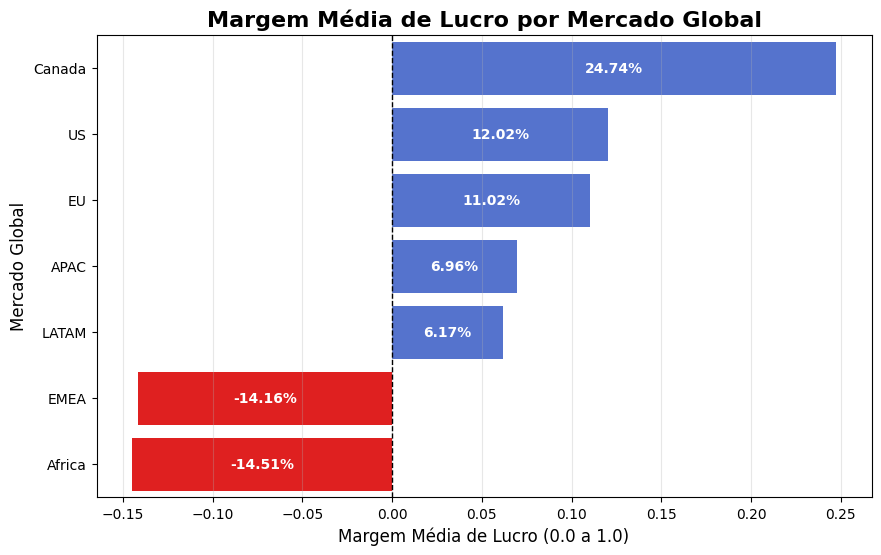

In [24]:
# 1. Custo Médio de Envio por Mercado
df_custo_envio_mercado = df_sales.groupby('market')['shipping_cost'].mean().reset_index()
df_custo_envio_mercado = df_custo_envio_mercado.sort_values(by='shipping_cost', ascending=False)
print("--- Custo Médio de Envio por Mercado Global ---")
print(df_custo_envio_mercado)


# 2. Margem Média de Lucro por Mercado Global
df_margem_mercado = df_sales.groupby('market')['margem_lucro'].mean().reset_index()
df_margem_mercado = df_margem_mercado.sort_values(by='margem_lucro', ascending=False)
print("\n--- Margem Média de Lucro por Mercado Global ---")
print(df_margem_mercado.round(4))


# CRIAÇÃO DO GRÁFICO (Margem Média por Mercado)

# DEFINIÇÃO DAS CORES CONDICIONAIS (Vermelho para prejuízo, Azul para lucro)
cores_margem = ['red' if m < 0 else 'royalblue' for m in df_margem_mercado['margem_lucro']]

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='margem_lucro',
    y='market',
    data=df_margem_mercado,
    palette=cores_margem
)

# FORMATO E TÍTULOS
plt.title('Margem Média de Lucro por Mercado Global', fontsize=16, fontweight='bold')
plt.xlabel('Margem Média de Lucro (0.0 a 1.0)', fontsize=12)
plt.ylabel('Mercado Global', fontsize=12)
plt.axvline(0, color='black', linewidth=1, linestyle='--') # Linha central em 0%
plt.grid(axis='x', alpha=0.3)

# EXIBIR VALOR DA BARRA (Em porcentagem)
for p in ax.patches:
    value = p.get_width()
    formatted_value = f"{value * 100:.2f}%"

    x_pos = p.get_x() + p.get_width() / 2

    ax.text(
        x_pos,
        p.get_y() + p.get_height() / 2,
        formatted_value,
        ha="center",
        va="center",
        color='white',
        fontsize=10,
        fontweight='bold'
    )

plt.show()

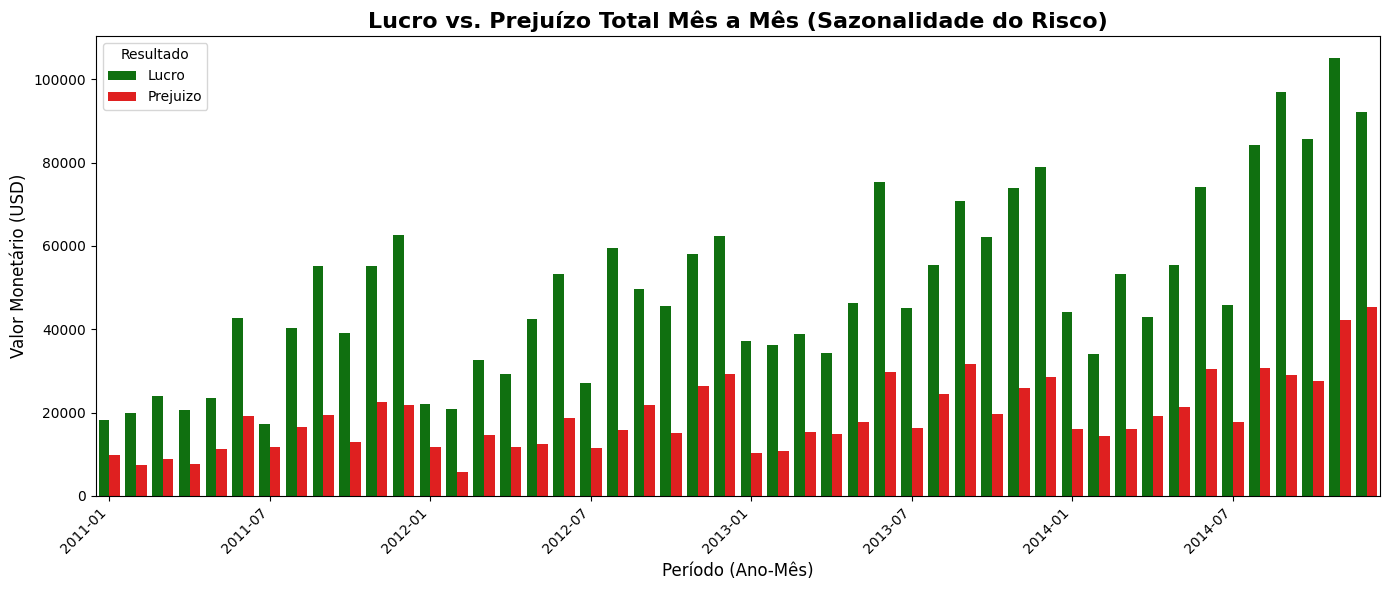

In [25]:
# O código foi unificado e corrigido para criar as colunas Lucro e Prejuízo Absoluto corretamente.

# 1. PREPARAÇÃO: Criar colunas separadas para Lucro e Prejuízo (absoluto)
df_sales['Ano_Mes'] = df_sales['order_date'].dt.to_period('M')

# Lucro Total Mensal (Apenas valores positivos)
df_sales['Lucro'] = np.where(df_sales['profit'] > 0, df_sales['profit'], 0)
# Prejuízo Total Mensal (Apenas valores negativos, mas em ABSOLUTO para plotagem)
df_sales['Prejuizo'] = np.where(df_sales['profit'] < 0, df_sales['profit'].abs(), 0)

# 2. AGRUPAMENTO: Soma os valores de Lucro e Prejuízo por Mês/Ano
df_sazonalidade = df_sales.groupby('Ano_Mes')[['Lucro', 'Prejuizo']].sum().reset_index()

# Converte 'Ano_Mes' para string para plotagem no eixo X
df_sazonalidade['Ano_Mes'] = df_sazonalidade['Ano_Mes'].astype(str)


# 3. CRIAÇÃO DO DATAFRAME PLOT (Melt)
df_plot = df_sazonalidade.melt(id_vars='Ano_Mes',
                               value_vars=['Lucro', 'Prejuizo'],
                               var_name='Tipo_Resultado',
                               value_name='Valor')

# CRIAÇÃO DO GRÁFICO DE BARRAS AGRUPADAS (Sazonalidade)
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x='Ano_Mes',
    y='Valor',
    hue='Tipo_Resultado',
    data=df_plot,
    # Paleta de cores para representar Lucro (Verde) e Prejuízo (Vermelho)
    palette={'Lucro': 'green', 'Prejuizo': 'red'}
)

# FORMATO E TÍTULOS
plt.title('Lucro vs. Prejuízo Total Mês a Mês (Sazonalidade do Risco)', fontsize=16, fontweight='bold')
plt.xlabel('Período (Ano-Mês)', fontsize=12)
plt.ylabel('Valor Monetário (USD)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')

# Ajuste dos rótulos do eixo X (Reduz a densidade para legibilidade)
n = 6
ticks = df_sazonalidade['Ano_Mes'][::n]
labels = df_sazonalidade['Ano_Mes'][::n]
plt.xticks(ticks=ticks, labels=labels, rotation=45, ha='right')
plt.legend(title='Resultado', loc='upper left')
plt.tight_layout()

plt.show()